In [1]:

import argparse
import numpy as np
import matplotlib.pyplot as plt 
#import os
#import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import scipy
from scipy.integrate import solve_ivp
from sklearn.feature_extraction import image
from netCDF4 import Dataset
import datetime

# specific torch module 
#import dinAE_solver_torch as dinAE
import torch_4DVarNN_dinAE_Copy1 as NN_4DVar
#import torch4DVarNN_solver as NN_4DVar
import matplotlib.pyplot as plt


/anaconda/envs/4dvarnet/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554798336/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
parser = argparse.ArgumentParser()
flagProcess    = [0,1,2,3,4]#Sequence fo processes to be run
    
flagRandomSeed = 0
flagSaveModel  = 1
     
  
batch_size  = 96#4#4#8#12#8#256#8

dirSAVE     = './ResDanube4DVar/'
genFilename = 'Debit_v11'
  
flagAEType = 2 # 0: L96 model, 1-2: GENN
DimAE      = 50#50#10#50
    
UsePriodicBoundary = True # use a periodic boundary for all conv operators in the gradient model (see torch_4DVarNN_dinAE)
InterpFlag         = False

NbDays          = 18244


In [5]:
     
for kk in range(0,len(flagProcess)):
     if flagProcess[kk] == 0:        
        print('........ Data extraction')
        if flagRandomSeed == 0:
            print('........ Random seed set to 100')
            np.random.seed(100)
        
        ###############################################################
        ## data extraction
        ncfile = Dataset('Dataset_danube.nc',"r")
        L=[]
        for i in range(31):
            L.append(ncfile['S'+str(i+1)][:].reshape(18244,1))
        
        dataset = np.concatenate((L[0],L[1],L[2],L[3],L[4],L[5],L[6],L[7],L[8],L[9],L[10],L[11],L[12],L[13],L[14],L[15],L[16],L[17],L[18],L[19],L[20],L[21],L[22],L[23],L[24],L[25],L[26],L[27],L[28],L[29],L[30]),axis=1)
    
        i=0
        Indtrain=[]
        Indval=[]
        Indtest=[]
        while (i+1)*395<(NbDays-1):
            x=395*i
            Indtrain.append([x,(x+305)])
            Indval.append([(x+319),(x+350)])
            Indtest.append([x+364,x+395])
            i+=1
    

        #Se restreindre à l'été car pas de pluie??
        day0=datetime.date(1960,1,1)
        dayend=datetime.date(2009,12,12)
    
         ####################################################
        ## Generation of training and test dataset
        ## Extraction of time series of dT time steps
        #NbTraining = 6000#2000
        #NbTest     = 256#256#500
        #NbVal = ?
        time_step  = 1
        DT = 21
        sigNoise   = np.sqrt(2)
        rateMissingData = 0.5#0.95
    
        dataTrainingNoNaND = image.extract_patches_2d(dataset[Indtrain[0][0]:Indtrain[0][1],:],(DT,31))
        
 
        for k in Indtrain[1::]:
            d= image.extract_patches_2d(dataset[k[0]:k[1],:],(DT,31))
            dataTrainingNoNaND=np.concatenate((dataTrainingNoNaND,d),axis=0)
        
    
        dataValNoNaND = image.extract_patches_2d(dataset[Indval[0][0]:Indval[0][1],:],(DT,31))
    
        for k in Indval[1::]:
            d= image.extract_patches_2d(dataset[k[0]:k[1],:],(DT,31))
            dataValNoNaND=np.concatenate((dataValNoNaND,d),axis=0)
        print(dataValNoNaND.shape )  
    
        dataTestNoNaND = image.extract_patches_2d(dataset[Indtest[0][0]:Indtest[0][1],:],(DT,31))
    
        for k in Indtest[1::]:
            d= image.extract_patches_2d(dataset[k[0]:k[1],:],(DT,31))
            dataTestNoNaND=np.concatenate((dataTestNoNaND,d),axis=0)
        print(dataTestNoNaND.shape ) 
        
        # create missing data
        #flagTypeMissData = 0 : Missing data randomly chosen on the patch driven by rateMissingData
        #flagTypeMissData = 1 : Almost the same
        #flagTypeMissData = 2 : In each patch, different station are randomly chosen and are masked according to rateMissingData
        #flagTypeMissData = 3 : The same stations listed in MaskedStations are masked
        flagTypeMissData = 2
        if flagTypeMissData == 0:
            indRandD         = np.random.permutation(dataTrainingNoNaND.shape[0]*dataTrainingNoNaND.shape[1]*dataTrainingNoNaND.shape[2])
            indRandD         = indRandD[0:int(rateMissingData*len(indRandD))]
            dataTrainingD    = np.copy(dataTrainingNoNaND).reshape((dataTrainingNoNaND.shape[0]*dataTrainingNoNaND.shape[1]*dataTrainingNoNaND.shape[2],1))
            dataTrainingD[indRandD] = float('nan')
            dataTrainingD    = np.reshape(dataTrainingD,(dataTrainingNoNaND.shape[0],dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]))
            
            indRandD         = np.random.permutation(dataValNoNaND.shape[0]*dataValNoNaND.shape[1]*dataValNoNaND.shape[2])
            indRandD         = indRandD[0:int(rateMissingData*len(indRandD))]
            dataValD    = np.copy(dataValNoNaND).reshape((dataValNoNaND.shape[0]*dataValNoNaND.shape[1]*dataValNoNaND.shape[2],1))
            dataValD[indRandD] = float('nan')
            dataValD    = np.reshape(dataValD,(dataValNoNaND.shape[0],dataValNoNaND.shape[1],dataValNoNaND.shape[2]))
            
            
            indRandD         = np.random.permutation(dataTestNoNaND.shape[0]*dataTestNoNaND.shape[1]*dataTestNoNaND.shape[2])
            indRandD         = indRandD[0:int(rateMissingData*len(indRandD))]
            dataTestD        = np.copy(dataTestNoNaND).reshape((dataTestNoNaND.shape[0]*dataTestNoNaND.shape[1]*dataTestNoNaND.shape[2],1))
            dataTestD[indRandD] = float('nan')
            dataTestD          = np.reshape(dataTestD,(dataTestNoNaND.shape[0],dataTestNoNaND.shape[1],dataTestNoNaND.shape[2]))

            genSuffixObs    = '_ObsRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
        
        elif flagTypeMissData==1:
            time_step_obs   = int(1./(1.-rateMissingData))
            dataTrainingD    = np.zeros((dataTrainingNoNaND.shape))
            dataTrainingD[:] = float('nan')
            
            dataValD    = np.zeros((dataValNoNaND.shape))
            dataValD[:] = float('nan')
            
            dataTestD        = np.zeros((dataTestNoNaND.shape))
            dataTestD[:]     = float('nan')
               
            if 1*0:
                
                dataTrainingD[:,::time_step_obs,:] = dataTrainingNoNaND[:,::time_step_obs,:]
                dataValD[:,::time_step_obs,:] = dataValNoNaND[:,::time_step_obs,:]
                dataTestD[:,::time_step_obs,:]     = dataTestNoNaND[:,::time_step_obs,:]
                    
                genSuffixObs    = '_ObsSub_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
            else:
                for nn in range(0,dataTrainingD.shape[1],time_step_obs):
                    indrand = np.random.permutation(dataTrainingD.shape[2])[0:int(0.5*dataTrainingD.shape[1])]
                    dataTrainingD[:,nn,indrand] = dataTrainingNoNaND[:,nn,indrand]
                    
                for nn in range(0,dataTrainingD.shape[1],time_step_obs):
                    indrand = np.random.permutation(dataTrainingD.shape[2])[0:int(0.5*dataTrainingD.shape[1])]
                    dataValD[:,nn,indrand] = dataValNoNaND[:,nn,indrand]
                    
                for nn in range(0,dataTrainingD.shape[1],time_step_obs):
                    indrand = np.random.permutation(dataTrainingD.shape[2])[0:int(0.5*dataTrainingD.shape[1])]
                    dataTestD[:,nn,indrand] = dataTestNoNaND[:,nn,indrand]

                genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
        elif flagTypeMissData == 2 :
            #
            Nbtraining=13110
            Nbval=506
            Nbtest=506
            
            ratemissingdata_space = 0.15
            time_step_obs   = int(1./(1.-rateMissingData))
            dataTrainingD    = np.zeros(([Nbtraining,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
            dataTrainingD[:] = float('nan')
            dataTrainingNoNaND2    = np.zeros(([Nbtraining,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
            dataTrainingNoNaND2[:] = float('nan')
            
            dataValD    = np.zeros(([Nbval,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))           
            dataValD[:] = float('nan')
            dataValNoNaND2=np.zeros(([Nbval,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
            dataValNoNaND2[:] = float('nan')
            
            dataTestD        = np.zeros(([Nbtest,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
            dataTestD[:]     = float('nan') 
            dataTestNoNaND2 =np.zeros(([Nbtest,dataTrainingNoNaND.shape[1],dataTrainingNoNaND.shape[2]]))
            dataTestNoNaND2[:] = float('nan')
            
            ind=0
            print(dataTrainingD.shape)
            while ind<Nbtraining:
                indrand=np.random.permutation(dataTrainingD.shape[2])[0:int((1-ratemissingdata_space)*dataTrainingD.shape[2])]
                dataTrainingD[ind,:,indrand]=dataTrainingNoNaND[ind%dataTrainingNoNaND.shape[0],:,indrand]
                dataTrainingNoNaND2[ind,:,:]=dataTrainingNoNaND[ind%dataTrainingNoNaND.shape[0],:,:]
                
                if ind <Nbval:
                    indrand2=np.random.permutation(dataTrainingD.shape[2])[0:int((1-ratemissingdata_space)*dataTrainingD.shape[2])]
                    dataValD[ind,:,indrand2]=dataValNoNaND[ind%dataValNoNaND.shape[0],:,indrand2]
                    dataValNoNaND2[ind,:,:]=dataValNoNaND[ind%dataValNoNaND.shape[0],:,:]
                
                    indrand3=np.random.permutation(dataTrainingD.shape[2])[0:int((1-ratemissingdata_space)*dataTrainingD.shape[2])]
                    dataTestD[ind,:,indrand3]=dataTestNoNaND[ind%dataTestNoNaND.shape[0],:,indrand3]
                    dataTestNoNaND2[ind,:,:] = dataTestNoNaND[ind%dataTestNoNaND.shape[0],:,:]
                ind+=1
                
            dataTrainingNoNaND =dataTrainingNoNaND2
            dataValNoNaND = dataValNoNaND2
            dataTestNoNaND =dataTestNoNaND2        
            genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2) 
        
        #mask only on specific station
        else :
            MaskedStations=[2,4,16,25]
            
            dataTrainingD    = np.zeros((dataTrainingNoNaND.shape))
            dataTrainingD[:] = float('nan')
            
            dataValD    = np.zeros((dataValNoNaND.shape))
            dataValD[:] = float('nan')
            
            dataTestD        = np.zeros((dataTestNoNaND.shape))
            dataTestD[:]     = float('nan')
            print(dataTrainingNoNaND[0,:,:])  
            for i in range(31):
                dataTrainingD[:,:,i] = dataTrainingNoNaND[:,:,i]
                dataValD[:,:,i] = dataValNoNaND[:,:,i]
                dataTestD[:,:,i] = dataTestNoNaND[:,:,i]
            for i in MaskedStations:
                dataTrainingD[:,:,i-1] = float('nan')
                dataValD[:,:,i-1] = float('nan')
                dataTestD[:,:,i-1] = float('nan')
            genSuffixObs    = '_ObsSubRnd_%02d_%02d'%(100*rateMissingData,10*sigNoise**2)
            print(dataTrainingNoNaND[0,:,:])    
        print('... Data type: '+genSuffixObs)
            #for nn in range(0,dataTraining.shape[1],time_step_obs):
            #    dataTraining[:,::time_step_obs,:] = dataTrainingNoNaN[:,::time_step_obs,:]
            #dataTest    = np.zeros((dataTestNoNaN.shape))
            #dataTest[:] = float('nan')
            #dataTest[:,::time_step_obs,:] = dataTestNoNaN[:,::time_step_obs,:]
        
        # set to NaN patch boundaries    
        if 1*0:
            dataTrainingD[:,0:10,:] =  float('nan')
            dataValD[:,0:10,:] =  float('nan')
            dataTestD[:,0:10,:]     =  float('nan')
            dataTrainingD[:,dT-10:dT,:] =  float('nan')
            dataValD[:,dT-10:dT,:] =  float('nan')
            dataTestD[:,dT-10:dT,:]     =  float('nan')
            
        flagTypeConstantMask=0
        
        
            
            
        # mask for NaN
        maskTrainingD = (dataTrainingD == dataTrainingD).astype('float')
        maskValD = (dataValD == dataValD).astype('float')
        maskTestD     = ( dataTestD    ==  dataTestD   ).astype('float')
            
        dataTrainingD = np.nan_to_num(dataTrainingD)
        
        dataValD = np.nan_to_num(dataValD)
        dataTestD     = np.nan_to_num(dataTestD)
            
            # Permutation to have channel as #1 component
        dataTrainingD      = np.moveaxis(dataTrainingD,-1,1)
        maskTrainingD      = np.moveaxis(maskTrainingD,-1,1)
        dataTrainingNoNaND = np.moveaxis(dataTrainingNoNaND,-1,1)
        
        dataValD      = np.moveaxis(dataValD,-1,1)
        maskValD      = np.moveaxis(maskValD,-1,1)
        dataValNoNaND = np.moveaxis(dataValNoNaND,-1,1)
            
        dataTestD      = np.moveaxis(dataTestD,-1,1)
        maskTestD      = np.moveaxis(maskTestD,-1,1)
        dataTestNoNaND = np.moveaxis(dataTestNoNaND,-1,1)
            
        # set to NaN patch boundaries
        #dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
        #dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]
    
############################################
        ## raw data
        X_trainD         = dataTrainingNoNaND
        
        X_train_missingD = dataTrainingD
        mask_trainD      = maskTrainingD
         
        X_valD         = dataValNoNaND
        X_val_missingD = dataValD
        mask_valD      = maskValD
        
        X_testD         = dataTestNoNaND
        X_test_missingD = dataTestD
        mask_testD      = maskTestD
            
        ############################################
        ## normalized data wrt to each measurement station
        
        if flagTypeMissData ==2 :
            mean2 = np.mean(X_train_missingD[:],0)
            mean2mask = np.mean(mask_trainD[:],0)


            mean3 = np.mean(mean2,1)
            mean3 = mean3.reshape(31,1)
            print(mean3)
            mean3mask = np.mean(mean2mask,1)
            mean3mask = mean3mask.reshape(31,1)
            print(mean3mask)
            meanTr          = mean3/mean3mask
            print(meanTr)
            mean2true = np.mean(X_trainD[:],0)
            mean3true = np.mean(mean2true,1)
            mean3true = mean3true.reshape(31,1)
            meanTrtrue = mean3true
            print(meanTrtrue)
            
            meansquaretrue = np.mean( (X_trainD-meanTrtrue)**2,0)
            meansquare2true = np.mean(meansquaretrue,1)
            meansquare2true=meansquare2true.reshape(31,1)
            stdTrtrue           = np.sqrt(meansquare2true )
            print(stdTrtrue)
            
            
            x_train_missingD = X_train_missingD - meanTr*mask_trainD
            
            x_val_missingD = X_val_missingD - meanTr*mask_valD
            x_test_missingD  = X_test_missingD - meanTr*mask_testD
            
            # scale wrt to each station
            meansquare = np.mean( X_train_missingD**2,0)
            meansquare2 = np.mean(meansquare,1)
            meansquare2=meansquare2.reshape(31,1)
            stdTr           = np.sqrt(meansquare2 / mean3mask)
            
            x_train_missingD = x_train_missingD / stdTr
            x_val_missingD = x_val_missingD / stdTr
            x_test_missingD  = x_test_missingD / stdTr
            
            x_trainD = (X_trainD - meanTr) / stdTr
            x_valD = (X_valD - meanTr) / stdTr
            x_testD  = (X_testD - meanTr) / stdTr
            
            print(np.mean(x_train_missingD))
            print(np.mean(x_trainD))
            print(np.mean(x_val_missingD))
            print(np.mean(x_valD))
            print(np.mean(x_test_missingD))
            print(np.mean(x_testD))
            
            
               
        elif flagTypeMissData==3 :
            mean2 = np.mean(X_train_missingD[:],0)
            mean3 = np.mean(mean2,1)
            mean3 = mean3.reshape(31,1)
            meanTr = mean3
            x_train_missingD = X_train_missingD - meanTr
            x_val_missingD = X_val_missingD - meanTr
            x_test_missingD  = X_test_missingD - meanTr
            meansquare = np.mean( x_train_missingD**2,0)
            meansquare2 = np.mean(meansquare,1)
            meansquare2=meansquare2.reshape(31,1)
            
            stdTr           = np.sqrt(meansquare2)
            
            for i in MaskedStations :
                stdTr[i-1] =1
            print(stdTr)
            print(X_trainD[0,:,:])
            x_train_missingD = x_train_missingD / stdTr
            x_val_missingD = x_val_missingD / stdTr
            x_test_missingD  = x_test_missingD / stdTr
            mean2true = np.mean(X_trainD[:],0)
            mean3true = np.mean(mean2true,1)
            mean3true = mean3true.reshape(31,1)
            meanTrtrue = mean3true
            
            meansquaretrue = np.mean( (X_trainD-meanTrtrue)**2,0)
            meansquare2true = np.mean(meansquaretrue,1)
            meansquare2true=meansquare2true.reshape(31,1)
            stdTrtrue           = np.sqrt(meansquare2true )
            print(stdTrtrue)
            print(meanTrtrue)
            
            x_trainD = (X_trainD - meanTrtrue) / stdTrtrue
            x_valD = (X_valD - meanTrtrue) / stdTrtrue
            x_testD  = (X_testD - meanTrtrue) / stdTrtrue
            
            
            
        else : 
            mean2 = np.mean(X_train_missingD[:],0)
            mean2mask = np.mean(mask_trainD[:],0)
            

            mean3 = np.mean(mean2,1)
            mean3 = mean3.reshape(31,1)
            print(mean3)
            mean3mask = np.mean(mean2mask,1)
            mean3mask = mean3mask.reshape(31,1)
            print(mean3mask)
            meanTr          = mean3/mean3mask
            print(meanTr)
            
            x_train_missingD = X_train_missingD - meanTr*mask_trainD
            x_val_missingD = X_val_missingD - meanTr
            x_test_missingD  = X_test_missingD - meanTr
            
            # scale wrt to each station
            meansquare = np.mean( X_train_missingD**2,0)
            meansquare2 = np.mean(meansquare,1)
            meansquare2=meansquare2.reshape(31,1)
            stdTr           = np.sqrt(meansquare2 / mean3mask)
            
            x_train_missingD = x_train_missingD / stdTr
            x_val_missingD = x_val_missingD / stdTr
            x_test_missingD  = x_test_missingD / stdTr
            
            x_trainD = (X_trainD - meanTr) / stdTr
            x_valD = (X_valD - meanTr) / stdTr
            x_testD  = (X_testD - meanTr) / stdTr
            
        # Generate noisy observsation
        
        #X_train_obsD = X_train_missingD + sigNoise * maskTrainingD * np.random.randn(X_train_missingD.shape[0],X_train_missingD.shape[1],X_train_missingD.shape[2])
        #X_val_obsD = X_val_missingD + sigNoise * maskValD * np.random.randn(X_val_missingD.shape[0],X_val_missingD.shape[1],X_val_missingD.shape[2])
        #X_test_obsD  = X_test_missingD  + sigNoise * maskTestD * np.random.randn(X_test_missingD.shape[0],X_test_missingD.shape[1],X_test_missingD.shape[2])
            
        #x_train_obsD = (X_train_obsD - meanTr) / stdTr
        #x_val_obsD = (X_val_obsD - meanTr) / stdTr
        #x_test_obsD  = (X_test_obsD - meanTr) / stdTr
        
        #Without noise :
        X_train_obsD = X_train_missingD 
        X_val_obsD = X_val_missingD 
        X_test_obsD  = X_test_missingD
        
        x_train_obsD = x_train_missingD
        x_val_obsD = x_val_missingD
        x_test_obsD = x_test_missingD 
        
        print('..... Training dataset: %dx%dx%d'%(x_train_missingD.shape[0],x_trainD.shape[1],x_trainD.shape[2]))
        print('..... Validation dataset: %dx%dx%d'%(x_valD.shape[0],x_valD.shape[1],x_valD.shape[2]))
        print('..... Test dataset    : %dx%dx%d'%(x_testD.shape[0],x_testD.shape[1],x_testD.shape[2]))
            
    

........ Data extraction
........ Random seed set to 100
(506, 21, 31)
(506, 21, 31)
(13110, 21, 31)
... Data type: _ObsSubRnd_50_20
[[1182.27609967]
 [ 534.48376012]
 [ 383.32143039]
 [ 373.95863318]
 [ 296.81866841]
 [ 279.93976536]
 [ 262.40468054]
 [ 163.66804911]
 [ 137.58971705]
 [ 103.79635574]
 [  38.56906335]
 [  17.58970074]
 [ 613.64553049]
 [ 143.77420762]
 [ 133.00062402]
 [  52.26245687]
 [  39.46680215]
 [  22.67406574]
 [  16.65114431]
 [  93.91424794]
 [  66.43911409]
 [  58.07917482]
 [  41.61474374]
 [  31.77962856]
 [  31.20871632]
 [  28.52240315]
 [  21.53041826]
 [  34.67270375]
 [  30.76021612]
 [ 210.80894047]
 [ 198.7232665 ]]
[[0.83790999]
 [0.83913043]
 [0.83348589]
 [0.83539283]
 [0.83470633]
 [0.83920671]
 [0.83661327]
 [0.84103738]
 [0.84157132]
 [0.83295195]
 [0.8382151 ]
 [0.84424104]
 [0.83874905]
 [0.84035088]
 [0.83501144]
 [0.83897788]
 [0.83737605]
 [0.84370709]
 [0.84180015]
 [0.83806255]
 [0.84279176]
 [0.83356217]
 [0.84050343]
 [0.84035088]
 [0

In [68]:
print(maskTrainingD[0,:,:])

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1.

In [6]:
                     
    ###############################################################
    kk=1
    if flagProcess[kk] == 1:        
        print('........ Initialize interpolated states')
        ## Initial interpolation
        flagInit = 0
            
        if flagInit == 0: 
            X_train_InitD = mask_trainD * X_train_obsD + (1. - mask_trainD) * (np.zeros(X_train_missingD.shape) + meanTr)
            X_val_InitD = mask_valD * X_val_obsD + (1. - mask_valD) * (np.zeros(X_val_missingD.shape) + meanTr)
            X_test_InitD  = mask_testD * X_test_obsD + (1. - mask_testD) * (np.zeros(X_test_missingD.shape) + meanTr)
        else:
            X_train_InitD = np.zeros(X_trainD.shape)
            for ii in range(0,X_trainD.shape[0]):
                # Initial linear interpolation for each component
                XInitD = np.zeros((X_trainD.shape[1],X_trainD.shape[2]))
           
                for kk in range(0,mask_trainD.shape[1]):
                    indt  = np.where( mask_trainD[ii,kk,:] == 1.0 )[0]
                    indt_ = np.where( mask_trainD[ii,kk,:] == 0.0 )[0]
           
                    if len(indt) > 1:
                        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
                        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
                        fkk = scipy.interpolate.interp1d(indt, X_train_obsD[ii,kk,indt])
                        XInitD[kk,indt]  = X_train_obsD[ii,kk,indt]
                        XInitD[kk,indt_] = fkk(indt_)
                    else:
                        XInitD = XInitD + meanTr
            
                X_train_InitD[ii,:,:] = XInitD
            
            X_val_InitD = np.zeros(X_valD.shape)
            for ii in range(0,X_valD.shape[0]):
                # Initial linear interpolation for each component
                XInitD = np.zeros((X_valD.shape[1],X_valD.shape[2]))
           
                for kk in range(0,mask_valD.shape[1]):
                    indt  = np.where( mask_valD[ii,kk,:] == 1.0 )[0]
                    indt_ = np.where( mask_valD[ii,kk,:] == 0.0 )[0]
           
                    if len(indt) > 1:
                        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
                        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
                        fkk = scipy.interpolate.interp1d(indt, X_val_obsD[ii,kk,indt])
                        XInitD[kk,indt]  = X_val_obsD[ii,kk,indt]
                        XInitD[kk,indt_] = fkk(indt_)
                    else:
                        XInitD = XInitD + meanTr
            
                X_val_InitD[ii,:,:] = XInitD
            
            X_test_InitD = np.zeros(X_testD.shape)
            for ii in range(0,X_testD.shape[0]):
                # Initial linear interpolation for each component
                XInit = np.zeros((X_testD.shape[1],X_testD.shape[2]))
            
                for kk in range(0,X_testD.shape[1]):
                    indt  = np.where( mask_testD[ii,kk,:] == 1.0 )[0]
                    indt_ = np.where( mask_testD[ii,kk,:] == 0.0 )[0]
            
                    if len(indt) > 1:
                        indt_[ np.where( indt_ < np.min(indt)) ] = np.min(indt)
                        indt_[ np.where( indt_ > np.max(indt)) ] = np.max(indt)
                        fkk = scipy.interpolate.interp1d(indt, X_test_obsD[ii,kk,indt])
                        XInit[kk,indt]  = X_test_obsD[ii,kk,indt]
                        XInit[kk,indt_] = fkk(indt_)
                    else:
                        XInit = XInit + meanTr
        
                X_test_InitD[ii,:,:] = XInit
             #plt.figure()
              #plt.figure()
              #plt.plot(YObs[0:200,1],'r.')
              #plt.plot(XGT[0:200,1],'b-')
              #plt.plot(XInit[0:200,1],'k-')
                        
        x_train_InitD = ( X_train_InitD - meanTr ) / stdTr
        x_val_InitD = ( X_val_InitD - meanTr ) / stdTr
        x_test_InitD = ( X_test_InitD - meanTr ) / stdTr
        
        # reshape to dT-1 for time dimension
        DT = DT-1
        X_train_obsD        = X_train_obsD[:,:,0:DT]
        X_trainD            = X_trainD[:,:,0:DT]
        X_train_missingD    = X_train_missingD[:,:,0:DT]
        mask_trainD         = mask_trainD[:,:,0:DT]
            
        x_train_obsD        = x_train_obsD[:,:,0:DT]
        x_trainD            = x_trainD[:,:,0:DT]
        x_train_InitD       = x_train_InitD[:,:,0:DT]
        X_train_InitD       = X_train_InitD[:,:,0:DT]
        
        X_val_obsD        = X_val_obsD[:,:,0:DT]
        X_valD            = X_valD[:,:,0:DT]
        X_val_missingD    = X_val_missingD[:,:,0:DT]
        mask_valD         = mask_valD[:,:,0:DT]
            
        x_val_obsD        = x_val_obsD[:,:,0:DT]
        x_valD            = x_valD[:,:,0:DT]
        x_val_InitD       = x_val_InitD[:,:,0:DT]
        X_val_InitD       = X_val_InitD[:,:,0:DT]

        X_test_obsD        = X_test_obsD[:,:,0:DT]
        X_testD            = X_testD[:,:,0:DT]
        X_test_missingD    = X_test_missingD[:,:,0:DT]
        mask_testD         = mask_testD[:,:,0:DT]

        x_test_obsD        = x_test_obsD[:,:,0:DT]
        x_testD            = x_testD[:,:,0:DT]
        x_test_InitD       = x_test_InitD[:,:,0:DT]
        X_test_InitD       = X_test_InitD[:,:,0:DT]

        print('..... Training dataset: %dx%dx%d'%(x_trainD.shape[0],x_trainD.shape[1],x_trainD.shape[2]))
        print('..... Validation dataset: %dx%dx%d'%(x_valD.shape[0],x_valD.shape[1],x_valD.shape[2]))
        print('..... Test dataset    : %dx%dx%d'%(x_testD.shape[0],x_testD.shape[1],x_testD.shape[2]))


........ Initialize interpolated states
..... Training dataset: 13110x31x20
..... Validation dataset: 506x31x20
..... Test dataset    : 506x31x20


In [7]:

mean2= np.mean(X_train_missingD[:],0)
mean2true = np.mean(X_trainD[:],0)
mean2mask=np.mean(mask_trainD[:],0)


mean3 = np.mean(mean2,1)
mean3 = mean3.reshape(31,1)
mean3true = np.mean(mean2true,1)
mean3true = mean3true.reshape(31,1)
mean3mask = np.mean(mean2mask,1)
mean3mask = mean3mask.reshape(31,1)
m=mean3/mean3mask
print(mean3true)
print(mean3mask)
ytest=X_train_missingD-m
print(ytest[0,:,:])
print(X_train_missingD[0,:,:])

meansquare = np.mean( X_train_missingD**2,0)

meansquare2 = np.mean(meansquare,1)
meansquare2 = meansquare2.reshape(31,1)
print(meansquare2)
stdTr           = np.sqrt(meansquare2 / mean3mask)
print(stdTr)
print(m.shape)
ytest=ytest/stdTr
print(np.mean(ytest))



[[1408.42902365]
 [ 636.38589626]
 [ 459.15662471]
 [ 447.42198322]
 [ 355.37951106]
 [ 333.41799771]
 [ 313.74266743]
 [ 194.5539939 ]
 [ 164.09467201]
 [ 123.86004005]
 [  45.90348879]
 [  20.95869249]
 [ 732.4106865 ]
 [ 171.12276659]
 [ 159.68020633]
 [  62.17426964]
 [  47.17890923]
 [  27.02018158]
 [  19.73408879]
 [ 112.28795423]
 [  78.91789512]
 [  69.72168879]
 [  49.62999695]
 [  37.70486583]
 [  37.23775214]
 [  33.88724531]
 [  25.67608871]
 [  41.13099649]
 [  36.90155858]
 [ 251.06799275]
 [ 236.38016819]]
[[0.83790999]
 [0.83913043]
 [0.83348589]
 [0.83539283]
 [0.83470633]
 [0.83920671]
 [0.83661327]
 [0.84103738]
 [0.84157132]
 [0.83295195]
 [0.8382151 ]
 [0.84424104]
 [0.83874905]
 [0.84035088]
 [0.83501144]
 [0.83897788]
 [0.83737605]
 [0.84370709]
 [0.84180015]
 [0.83806255]
 [0.84279176]
 [0.83356217]
 [0.84050343]
 [0.84035088]
 [0.83775744]
 [0.83989321]
 [0.84004577]
 [0.8423341 ]
 [0.83524027]
 [0.83867277]
 [0.84035088]]
[[-4.60058876e+02 -4.95058876e+02 -5.

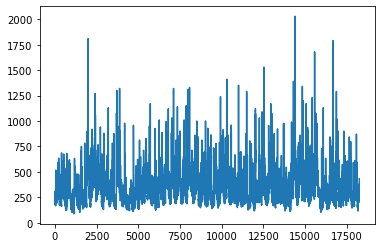

In [8]:
plt.figure(0)
plt.plot(dataset[:,5])


In [10]:
###############################################################
        ## AE architecture
kk=2
if flagProcess[kk] == 2:        
    print('........ Define AE architecture')
            
    shapeData = np.ones(3).astype(int)
    shapeData[1:] =  x_trainD.shape[1:]
    # freeze all ode parameters
            
    if flagAEType == -1: ## AE using ode_L63
            
        class Encoder(torch.nn.Module):
            def __init__(self):
                    super(Encoder, self).__init__()
                    self.F         = torch.nn.Parameter(torch.Tensor([8.]))
                    self.dt        = 0.05
                    self.IntScheme = 0
                    self.stdTr     = stdTr
                    self.meanTr    = meanTr
                    #self.conv1     = torch.nn.Conv2d(1,shapeData[0],1,padding=0,bias=False)
                        
            def _odeL96(self, xin):
                dx  = (xin[:,:,3:,:]-xin[:,:,0:xin.size(2)-3,:]) * xin[:,:,1:xin.size(2)-2,:] - xin[:,:,2:xin.size(2)-1,:]
                dx0 = (xin[:,:,1,:]-xin[:,:,xin.size(2)-2,:]) * xin[:,:,xin.size(2)-1,:] - xin[:,:,0,:]
                dx1 = (xin[:,:,2,:]-xin[:,:,xin.size(2)-1,:]) * xin[:,:,0,:] - xin[:,:,1,:]
                dxL = (xin[:,:,0,:]-xin[:,:,xin.size(2)-3,:]) * xin[:,:,xin.size(2)-2,:] - xin[:,:,xin.size(2)-1,:]
                                
                dx0 = dx0.view(-1,1,1,xin.size(3))
                dx1 = dx1.view(-1,1,1,xin.size(3))
                dxL = dxL.view(-1,1,1,xin.size(3))
                #print(dx.size())
                #print(dx0.size())
                #print(dx1.size())
                #print(dxL.size())
                dpred = torch.cat((dx0,dx1,dx,dxL),dim=2) + self.F
                return dpred
            
            def _EulerSolver(self, x):
                return x + self.dt * self._odeL96(x)
            
            def _RK4Solver(self, x):
                k1 = self._odeL96(x)
                x2 = x + 0.5 * self.dt * k1
                k2 = self._odeL96(x2)
                      
                x3 = x + 0.5 * self.dt * k2
                k3 = self._odeL96(x3)
                          
                x4 = x + self.dt * k3
                k4 = self._odeL96(x4)
            
                return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.
                  
            def forward(self, x):
                X = self.stdTr * x 
                X = X + self.meanTr
                        
                if self.IntScheme == 0:
                    xpred = self._EulerSolver( X[:,:,:,0:x.size(3)-1] )
                else:
                    xpred = self._RK4Solver( X[:,:,:,0:x.size(3)-1] )
            
                    xpred = xpred - self.meanTr
                    xpred = xpred / self.stdTr
            
                    xnew  = torch.cat((x[:,:,:,0].view(-1,1,x.size(2),1),xpred),dim=3)
                    return xnew
            
        class Decoder(torch.nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
            
            def forward(self, x):
                return torch.mul(1.,x)
                
        genSuffixModel = '_DinAE4DVar_MLP'  
        modelTemp      = Encoder()
        if modelTemp.IntScheme == 0 :
            genSuffixModel = genSuffixModel+'_L96EulerNN'
        elif modelTemp.IntScheme == 1 :
            genSuffixModel = genSuffixModel+'_L96RK4NN'
                    
    elif flagAEType == 0: ## AE using ode_L96 (conv2d implementation)
            
        class Encoder(torch.nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                self.F         = torch.nn.Parameter(torch.Tensor([8.]))
                self.dt        = 0.05
                self.IntScheme = 1
                self.stdTr     = stdTr
                self.meanTr    = meanTr
                #self.conv1     = torch.nn.Conv2d(1,shapeData[0],1,padding=0,bias=False)
                        
                self.conv1     = torch.nn.Conv2d(1,1,(5,1),padding=0,bias=False)
                self.conv2     = torch.nn.Conv2d(1,1,(3,1),padding=0,bias=False)

                # predefined parameters
                K = torch.Tensor([-1.,0.,0.,1.,0.]).view(1,1,5,1)
                self.conv1.weight = torch.nn.Parameter(K)
                K = torch.Tensor([1.,0.,0.]).view(1,1,3,1)
                self.conv2.weight = torch.nn.Parameter(K)
    
            def _odeL96(self, xin):
                x_1 = torch.cat((xin[:,:,xin.size(2)-2:,:],xin,xin[:,:,0:2,:]),dim=2)
                #x_1 = x_1.view(-1,1,xin.size(1)+4,xin.size(2))
                x_1 = self.conv1( x_1 )                
                #x_1 = x_1.view(-1,xin.size(1),xin.size(2))

                x_2 = torch.cat((xin[:,:,xin.size(2)-1:,:],xin,xin[:,:,0:1,:]),dim=2)
                #x_2 = x_2.view(-1,1,xin.size(1)+2,xin.size(2))
                x_2 = self.conv2( x_2 )
                #x_2 = x_2.view(-1,xin.size(1),xin.size(2))
                                
                dpred = x_1 * x_2 - xin + self.F
                
                return dpred.view(-1,xin.size(1),xin.size(2),xin.size(3))
            
            def _EulerSolver(self, x):
                return x + self.dt * self._odeL96(x)
            
            def _RK4Solver(self, x):
                k1 = self._odeL96(x)
                x2 = x + 0.5 * self.dt * k1
                k2 = self._odeL96(x2)
                      
                x3 = x + 0.5 * self.dt * k2
                k3 = self._odeL96(x3)
                          
                x4 = x + self.dt * k3
                k4 = self._odeL96(x4)
            
                return x + self.dt * (k1+2.*k2+2.*k3+k4)/6.
                  
            def forward(self, x):
                X = self.stdTr * x 
                X = X + self.meanTr
                        
                if self.IntScheme == 0:
                    xpred = self._EulerSolver( X[:,:,:,0:x.size(3)-1] )
                else:
                    xpred = self._RK4Solver( X[:,:,:,0:x.size(3)-1] )
            
                xpred = xpred - self.meanTr
                xpred = xpred / self.stdTr
            
                xnew  = torch.cat((x[:,:,:,0].view(-1,1,x.size(2),1),xpred),dim=3)
                return xnew
            
        class Decoder(torch.nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
            
            def forward(self, x):
                return torch.mul(1.,x)

        genSuffixModel = '_DinAE4DVarv1'  
        modelTemp      = Encoder()
        if modelTemp.IntScheme == 0 :
            genSuffixModel = genSuffixModel+'_L96EulerNN'
        elif modelTemp.IntScheme == 1 :
            genSuffixModel = genSuffixModel+'_L96RK4NN'
                    
    elif flagAEType == 1: ## Conv model with no use of the central point
        dW = 2
        genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
        class Encoder(torch.nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                self.conv1  = NN_4DVar.ConstrainedConv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
                self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv3  = torch.nn.Conv2d(2*DimAE,1,(1,1),padding=0,bias=False)
                #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)
            
                #self.conv2Tr = torch.nn.ConvTranspose1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,4,stride=4,bias=False)          
                #self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1,bias=False)
                #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)
            
            def forward(self, xin):
                x_1 = torch.cat((xin[:,:,xin.size(2)-dW:,:],xin,xin[:,:,0:dW,:]),dim=2)
                #x_1 = x_1.view(-1,1,xin.size(1)+2*dW,xin.size(2))
                x   = self.conv1( x_1 )
                x   = x[:,:,dW:xin.size(2)+dW,:]
                x   = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
                x   = self.conv3( x )
                #x = self.conv4( F.relu(x) )
                x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
                return x
        class Decoder(torch.nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
            
            def forward(self, x):
                      return torch.mul(1.,x)
                
    elif flagAEType == 2: ## Conv model with no use of the central point
        dW = 5
        genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
        class Encoder(torch.nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                self.pool1  = torch.nn.AvgPool2d((1,4))
                self.conv11 = NN_4DVar.ConstrainedConv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
                self.conv12 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
            
                self.convTr = torch.nn.ConvTranspose2d(DimAE,DimAE,(1,4),stride=(1,4),bias=False)          
                #self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1,bias=False)
                #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)
                self.conv11_1 = NN_4DVar.ConstrainedConv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
                self.conv12_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv21_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv22_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv23_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv3_1  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
            
                self.convF    = torch.nn.Conv2d(DimAE,1,1,padding=0,bias=False)
            def forward(self, xin):
                
                x_1 = self.pool1(xin)
                
                x_1 = torch.cat((x_1[:,:,x_1.size(2)-dW:,:],x_1,x_1[:,:,0:dW,:]),dim=2)
                
                #x_1 = x_1.view(-1,1,xin.size(1)+2*dW,xin.size(2))
                x   = self.conv11( x_1 )
               
                x   = self.conv12( F.relu(x) )
                
                x   = x[:,:,dW:xin.size(2)+dW,:]
                
                x   = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
                
                x   = self.conv3( x )
          
                x   = self.convTr( x )
                
                      
                x_2 = torch.cat((xin[:,:,xin.size(2)-dW:,:],xin,xin[:,:,0:dW,:]),dim=2)
                
                dx  = self.conv11_1( x_2 )
                
                dx  = self.conv12_1( F.relu(dx) )
                
                dx   = dx[:,:,dW:xin.size(2)+dW,:]
                
                dx   = torch.cat((self.conv21_1(dx), self.conv22_1(dx) * self.conv23_1(dx)),dim=1)
                
                dx   = self.conv3_1( dx )
                
                
                y=x+dx
                x    = self.convF( x + dx )
                
                #x = self.conv4( F.relu(x) )
                x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
                
                return x
        class Decoder(torch.nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
            
            def forward(self, x):
                return torch.mul(1.,x)
            
    elif flagAEType == 3: ## Same as flagAEType == 2 with no constraint on central point
        dW = 5
        genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
        class Encoder(torch.nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                self.pool1  = torch.nn.AvgPool2d((1,4))
                self.conv11 = torch.nn.Conv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
                self.conv12 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
            
                self.convTr = torch.nn.ConvTranspose2d(DimAE,DimAE,(1,4),stride=(1,4),bias=False)          
                #self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1,bias=False)
                #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)
                self.conv11_1 = torch.nn.Conv2d(1,DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)                      
                self.conv12_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv21_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv22_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv23_1 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv3_1  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
            
                self.convF    = torch.nn.Conv2d(DimAE,1,1,padding=0,bias=False)
            def forward(self, xin):
                x_1 = self.pool1(xin)
                x_1 = torch.cat((x_1[:,:,x_1.size(2)-dW:,:],x_1,x_1[:,:,0:dW,:]),dim=2)
                #x_1 = x_1.view(-1,1,xin.size(1)+2*dW,xin.size(2))
                x   = self.conv11( x_1 )
                x   = self.conv12( F.relu(x) )
                x   = x[:,:,dW:xin.size(2)+dW,:]
                x   = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
                x   = self.conv3( x )
                x   = self.convTr( x )
                      
                x_2 = torch.cat((xin[:,:,xin.size(2)-dW:,:],xin,xin[:,:,0:dW,:]),dim=2)
                print(xin.shape)
                print(xin.size(2))
                dx  = self.conv11_1( x_2 )
                dx  = self.conv12_1( F.relu(dx) )
                dx   = dx[:,:,dW:xin.size(2)+dW,:]
                dx   = torch.cat((self.conv21_1(dx), self.conv22_1(dx) * self.conv23_1(dx)),dim=1)
                dx   = self.conv3_1( dx )
                      
                x    = self.convF( x + dx )
                #x = self.conv4( F.relu(x) )
                x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
                return x
        class Decoder(torch.nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
            
            def forward(self, x):
                return torch.mul(1.,x)
            
    elif flagAEType == 4: ## Conv model with no use of the central point
        dW = 5
        genSuffixModel = '_GENN_%d_%02d_%02d'%(flagAEType,DimAE,dW)
        class Encoder(torch.nn.Module):
            def __init__(self):
                super(Encoder, self).__init__()
                self.pool1  = torch.nn.AvgPool2d(4)
                self.conv1  = NN_4DVar.ConstrainedConv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
                self.conv2  = torch.nn.Conv1d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
                      
                self.conv21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.conv3  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
                #self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0,bias=False)
            
                self.conv2Tr = torch.nn.ConvTranspose2d(DimAE,1,(4,4),stride=(4,4),bias=False)          
                #self.conv5 = torch.nn.Conv1d(2*shapeData[0]*DimAE,2*shapeData[0]*DimAE,3,padding=1,bias=False)
                #self.conv6 = torch.nn.Conv1d(2*shapeData[0]*DimAE,shapeData[0],1,padding=0,bias=False)
                #self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1,bias=False)
            
                self.convHR1  = NN_4DVar.ConstrainedConv2d(1,2*DimAE,(2*dW+1,2*dW+1),padding=dW,bias=False)
                self.convHR2  = torch.nn.Conv2d(2*DimAE,DimAE,(1,1),padding=0,bias=False)
                      
                self.convHR21 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.convHR22 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.convHR23 = torch.nn.Conv2d(DimAE,DimAE,(1,1),padding=0,bias=False)
                self.convHR3  = torch.nn.Conv2d(2*DimAE,1,(1,1),padding=0,bias=False)

            def forward(self, xinp):
                #x = self.fc1( torch.nn.Flatten(x) )
                #x = self.pool1( xinp )
                x = self.pool1( xinp )
                x = self.conv1( x )
                x = self.conv2( F.relu(x) )
                x = torch.cat((self.conv21(x), self.conv22(x) * self.conv23(x)),dim=1)
                x = self.conv3( x )
                x = self.conv2Tr( x )
                #x = self.conv5( F.relu(x) )
                #x = self.conv6( F.relu(x) )
                      
                xHR = self.convHR1( xinp )
                xHR = self.convHR2( F.relu(xHR) )
                xHR = torch.cat((self.convHR21(xHR), self.convHR22(xHR) * self.convHR23(xHR)),dim=1)
                xHR = self.convHR3( xHR )
                      
                x   = torch.add(x,1.,xHR)
                      
                #x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
                return x
            
        class Decoder(torch.nn.Module):
            def __init__(self):
                super(Decoder, self).__init__()
            
            def forward(self, x):
                return torch.mul(1.,x)
 
    class Model_AE(torch.nn.Module):
        def __init__(self):
            super(Model_AE, self).__init__()
            self.encoder = Encoder()
            self.decoder = Decoder()
            
        def forward(self, x):
            x = self.encoder( x )
            x = self.decoder( x )
            return x

    model_AE           = Model_AE()
    
print(shapeData)
print(0)
print(20)
print(1)
print(2)
print(InterpFlag)
print(UsePriodicBoundary)
    

........ Define AE architecture
[ 1 31 20]
0
20
1
2
False
True


## Evaluation of pre-trained model

In [11]:
model2           = NN_4DVar.Model_4DVarNN_GradFP(model_AE,shapeData,0,5,1,2,InterpFlag,UsePriodicBoundary)

indtime=40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fileAEModelInit = 'ResDanube4DVar/Debit_v11_GENN_2_50_05_DT01_020_ObsSubRnd_50_20_Nproj00_Grad_01_02_10_modelAE_iter100.mod'
model2.model_AE.load_state_dict(torch.load(fileAEModelInit))
model2.model_Grad.load_state_dict(torch.load(fileAEModelInit.replace('_modelAE','_modelGrad')))
print(model2.model_Grad.convLayer[0].weight)
model2.to(device)
TD     =  [torch.Tensor(x_val_InitD[indtime,:,:]).reshape(1,31,20),torch.Tensor(x_val_obsD[indtime,:,:]).reshape(1,31,20),torch.Tensor(mask_valD[indtime,:,:]).reshape(1,31,20),torch.Tensor(x_valD[indtime,:,:]).reshape(1,31,20)]
for i in range(4):
    TD[i]     =    TD[i].view(-1,1,TD[i].shape[1],TD[i].shape[2])
    TD[i]     =    TD[i].to(device)
with torch.set_grad_enabled(True):
    TD[0]    = torch.autograd.Variable(TD[0], requires_grad=True)
    o2,hn,cn,ng= model2(TD[0],TD[1],TD[2],None,None)
o2=o2.cpu().detach()
print(np.mean(o2.numpy()-x_valD[indtime,:,:])**2)
plt.figure(0)
plt.imshow(o2[0,0,:,:])
plt.colorbar() 
plt.figure(1)
plt.imshow(x_valD[indtime,:,:])
plt.colorbar()


Opitm type 2


AttributeError: 'Model_4DVarNN_GradFP' object has no attribute 'model_AE'

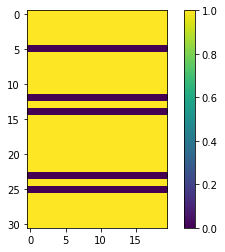

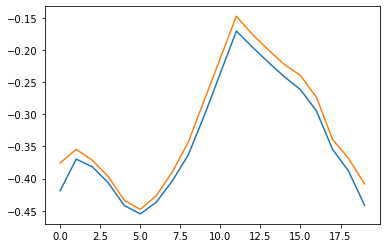

In [93]:
station = 1
plt.figure(0)
plt.imshow(mask_valD[indtime,:,:])
plt.colorbar()

plt.figure(1)
plt.plot(o2[0,0,station,:])
plt.plot(x_valD[indtime,station,:])


[[ 3.58930728]
 [ 2.57061547]
 [ 2.96578318]
 [ 2.74170505]
 [ 2.8443864 ]
 [ 2.34506876]
 [ 3.82861877]
 [ 4.79333905]
 [ 3.57976106]
 [ 7.83065879]
 [10.61088274]
 [ 8.81726923]
 [ 7.64692413]
 [ 4.86085903]
 [ 4.65063881]
 [ 8.37752448]
 [ 5.03039021]
 [ 3.33516999]
 [13.43375039]
 [ 6.46964385]
 [ 5.43911244]
 [21.23424382]
 [13.33621414]
 [ 5.51912192]
 [ 5.20151744]
 [ 6.05871696]
 [18.86666951]
 [13.65757175]
 [ 5.76824989]
 [ 5.11949266]
 [ 4.13551733]]
[433. 436. 440. 434. 416. 420. 418. 398. 408. 421. 419. 434. 423. 419.
 420. 425. 419. 437. 416. 428. 408. 419. 431. 437. 425. 428. 423. 425.
 435. 432. 429.]
[[0.00828939 0.00589591 0.00674042 0.00631729 0.00683747 0.0055835
  0.00915938 0.01204357 0.00877392 0.01860014 0.0253243  0.02031629
  0.01807783 0.0116011  0.01107295 0.01971182 0.0120057  0.00763197
  0.03229267 0.01511599 0.01333116 0.05067839 0.03094249 0.01262957
  0.01223886 0.01415588 0.04460206 0.03213546 0.01326034 0.01185068
  0.0096399 ]]


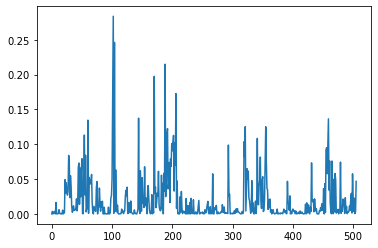

In [107]:
NbVal = x_valD.shape[0]
MS=[]
MStat = np.zeros((31,1),dtype='float')
for i in range(NbVal):
    Mask_i=[]
    for m in range(31):
        if mask_valD[i,m,0]==0:
            Mask_i.append(m)
    TD     =  [torch.Tensor(x_val_InitD[i,:,:]).reshape(1,31,20),torch.Tensor(x_val_obsD[i,:,:]).reshape(1,31,20),torch.Tensor(mask_valD[i,:,:]).reshape(1,31,20),torch.Tensor(x_valD[i,:,:]).reshape(1,31,20)]
    for k in range(4):
        TD[k]     =    TD[k].view(-1,1,TD[k].shape[1],TD[k].shape[2])
        TD[k]     =    TD[k].to(device)
    with torch.set_grad_enabled(True):
        TD[0]    = torch.autograd.Variable(TD[0], requires_grad=True)
        o,hn,cn,ng= model2(TD[0],TD[1],TD[2],None,None)
        o=o.cpu().detach()
    MS.append((np.mean(o.numpy()[0,0,Mask_i,:]-x_valD[i,Mask_i,:])**2))
    MStat[Mask_i,0]+=np.mean((o.numpy()[0,0,Mask_i,:]-x_valD[i,Mask_i,:])**2,1)
plt.figure(1)    
plt.plot(MS)
print(MStat)
MStat=MStat.reshape(1,31)
SumMask=sum(mask_valD[:,:,0],0)
print(SumMask)
print(MStat/SumMask)



(1, 31)


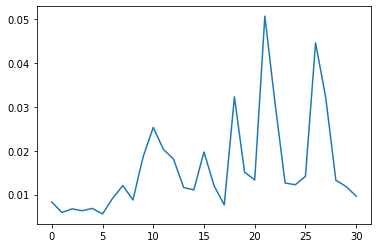

In [111]:
print((MStat/SumMask).shape)
plt.plot((MStat/SumMask)[0,:])

... Number of GPUs: 1


# AE Test

[[[[4.36973958e+00 2.05264959e-01 2.63384804e+00 7.78122376e+00
    7.55560695e-01 2.07330669e+01 5.98959696e+00 1.80586990e+00
    1.18257208e-01 2.50567990e+01 2.80579999e+00 1.25842660e+00
    6.45445562e-02 3.85925953e+00 1.82999107e+00 6.56467630e-01
    2.28125203e+00 9.37173134e+00 9.43912136e+00 1.85007662e+00]
   [4.60979790e+00 2.65982543e+01 4.02209342e+01 6.41066018e-01
    8.94158921e-01 9.82757624e+00 4.40302198e+00 1.70242615e-05
    2.04700970e+01 3.86197994e+01 9.03185979e+01 1.44371204e+00
    2.27469871e+00 1.46863594e+00 2.08820421e+01 6.92400691e+00
    4.39272516e+01 5.32526670e-03 1.46347798e+01 1.41505983e+01]
   [1.54785402e+00 3.55229932e-01 6.19874834e+00 1.01033186e+01
    1.44079358e+01 1.47886183e+01 1.80728089e+01 4.11249138e+01
    2.58445004e+00 5.95580575e+00 7.92155410e+00 2.21809815e+01
    1.58623344e+00 1.32358528e+00 3.44786898e+00 4.27724415e-01
    1.37322836e-01 1.87547245e+00 7.18762738e+00 1.31362822e-01]
   [6.50600689e+01 7.85843096e+01 8.2

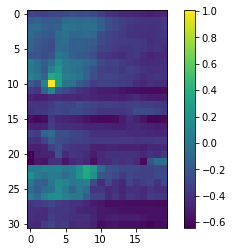

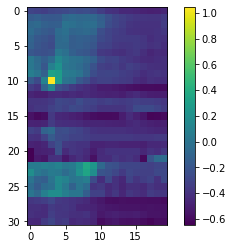

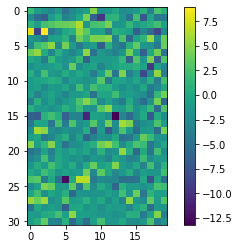

In [19]:
#

torch.Size([16, 31, 20])
torch.Size([16, 1, 31, 20])
torch.Size([16, 31, 20])
torch.Size([16, 1, 31, 20])


16
(1, 31, 20)
(20,)
(20,)


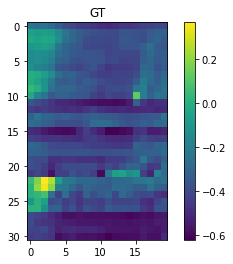

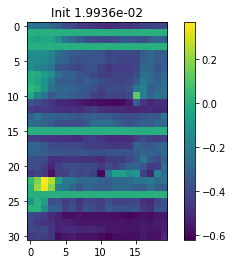

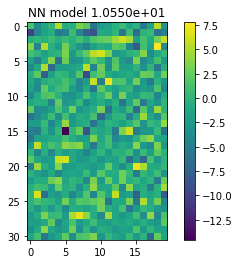

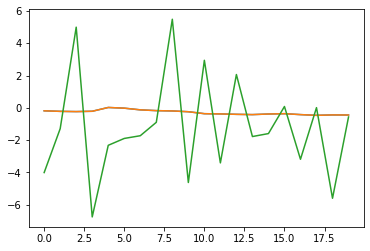

In [20]:
# Visualisation
#idxTr = np.random.permutation(y_train.shape[0])[0:2]

ii = 6

print(len(x_train_pred))
print(x_train_pred[0].shape)
print(x_train_pred[0][0,ii,:].shape)
print(x_trainD[0,1,:].shape)
plt.figure(1)
#plt.subplot(3,2,1)
plt.imshow(x_trainD[ii,:,:].squeeze(),cmap='viridis')
plt.title('GT')
plt.colorbar()
#plt.subplot(3,2,3)
plt.figure(2)
plt.imshow(x_train_InitD[ii,:,:].squeeze(),cmap='viridis')
plt.title('Init %.4e'%np.mean( (x_train_InitD[ii,:,:]-x_trainD[ii,:,:])**2 ))
plt.colorbar()
#plt.subplot(3,2,5)
plt.figure(4)
plt.imshow(x_train_pred[0][0,:,:].squeeze(),cmap='viridis')
plt.title('NN model %.4e'%np.mean( (x_train_pred[0][0,ii,:]-x_trainD[ii,:,:])**2 ))
plt.colorbar()
plt.figure(5)
plt.plot(x_trainD[0,ii,:])
plt.plot(x_train_InitD[0,ii,:])
plt.plot(x_train_pred[0][0,ii,:])

In [18]:
batch_size = 16

# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_InitD),torch.Tensor(x_train_obsD),torch.Tensor(mask_trainD),torch.Tensor(x_trainD)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_InitD),torch.Tensor(x_test_obsD),torch.Tensor(mask_testD),torch.Tensor(x_testD)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True),
}            
dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

y_train = np.zeros(x_trainD.shape)
y_test  = np.zeros(x_testD.shape)


# training function for dinAE
# Each epoch has a training and validation phase
for phase in ['val']:        
#for phase in ['train', 'val']:        

    since = time.time()

    model.eval()
        #if phase == 'train':
    #    #rint('Learning')
    #    model.train()  # Set model to training mode
    #else:
    #    #print('Evaluation')
    #    model.eval()   # Set model to evaluate mode

    running_loss_Obs     = 0.0
    running_loss_All     = 0.
    running_loss_R       = 0.
    running_loss_I       = 0.
    running_loss_AE      = 0.
    running_loss_AE_GT   = 0.
    running_loss_Obs_GT  = 0.
    num_loss             = 0
    idx = 0 # counter

    # Iterate over data.
    #for inputs_ in dataloaders[phase]:
    #    inputs = inputs_[0].to(device)
    for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
        if( np.mod(idx,500) == 0) :
            print(".. "+phase+" data %d"%idx)
        inputs_init    = inputs_init.to(device)
        inputs_missing = inputs_missing.to(device)
        masks          = masks.to(device)
        targets_GT     = targets_GT.to(device)
        #print(inputs_init.size(0))
        
                # reshaping tensors
        inputs_init    = inputs_init.view(-1,1,inputs_init.size(1),inputs_init.size(2))
        inputs_missing = inputs_missing.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        masks          = masks.view(-1,1,inputs_init.size(2),inputs_init.size(3))
        targets_GT     = targets_GT.view(-1,1,inputs_init.size(2),inputs_init.size(3))
                                
        # forward
        # need to evaluate grad/backward during the evaluation and training phase for model_AE
        with torch.set_grad_enabled(True): 
            #with torch.set_grad_enabled(phase == 'train'):
            inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
            if model.OptimType == 1:
                outputs,grad_new,normgrad = modelMultiGPU(inputs_init,inputs_missing,masks,None)
                
            elif model.OptimType == 2:
                outputs,hidden_new,cell_new,normgrad = model(inputs_init,inputs_missing,masks,None,None)
                
            else:                               
                outputs,normgrad = modelMultiGPU(inputs_init,inputs_missing,masks)

            # store interpolation/reconstruction results
            if phase == 'train':
                y_train[idx:idx+inputs_missing.size(0),:,:] = outputs.cpu().detach().numpy().squeeze()
            else:
                y_test[idx:idx+inputs_missing.size(0),:,:]  = outputs.cpu().detach().numpy().squeeze()

            idx += inputs_missing.size(0)

            #outputs = model(inputs_init,inputs_missing,masks)
            
            loss_R      = torch.sum((outputs - targets_GT)**2 * masks ) / torch.sum(masks)
            loss_Obs    = torch.sum((outputs - inputs_missing)**2 * masks ) / torch.sum(masks)
            loss_I      = torch.sum((outputs - targets_GT)**2 * (1. - masks) ) / torch.sum(1.-masks)
            loss_All    = torch.mean((outputs - targets_GT)**2 )
            loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )

            loss_AE_GT  = torch.mean((model.model_AE(targets_GT) - targets_GT)**2 )
            loss_Obs_GT = torch.sum((targets_GT - inputs_missing)**2 * masks ) / torch.sum(masks)
            #loss_AE_GT  = torch.mean((mod.model_AE(targets_GT) - targets_GT)**2 )

            #loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #if phase == 'train':                                 
            #    loss  = alpha_Grad * loss_All + 0.5 * alpha_AE * ( loss_AE + loss_AE_GT )
            #else:
            #    loss    = alpha_Grad * loss_R + alpha_AE * loss_AE

            # backward + optimize only if in training phase
                            
        # statistics
        running_loss_I           += loss_I.item() * inputs_missing.size(0)
        running_loss_R           += loss_R.item() * inputs_missing.size(0)
        running_loss_Obs         += loss_Obs.item() * inputs_missing.size(0)
        running_loss_Obs_GT      += loss_Obs_GT.item() * inputs_missing.size(0)
        running_loss_All         += loss_All.item() * inputs_missing.size(0)
        running_loss_AE_GT       += loss_AE_GT.item() * inputs_missing.size(0)
        running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)

    epoch_loss_All   = running_loss_All / num_loss
    epoch_loss_AE    = running_loss_AE / num_loss
    epoch_loss_AE_GT = running_loss_AE_GT / num_loss
    epoch_loss_I     = running_loss_I / num_loss
    epoch_loss_R     = running_loss_R / num_loss
    epoch_loss_Obs   = running_loss_Obs / num_loss
    epoch_loss_Obs_GT= running_loss_Obs_GT / num_loss
    #epoch_acc = running_corrects.double() / dataset_sizes[phase]

    epoch_loss_All   = epoch_loss_All 
    epoch_loss_I     = epoch_loss_I 
    epoch_loss_R     = epoch_loss_R 
    epoch_loss_Obs   = epoch_loss_Obs 
    epoch_loss_Obs_GT= epoch_loss_Obs_GT 
    epoch_loss_AE    = epoch_loss_AE 
    epoch_loss_AE_GT = epoch_loss_AE_GT 
    
    epoch_loss_4DVar = alpha4DVar[0] * epoch_loss_Obs + alpha4DVar[1] * epoch_loss_AE
    epoch_loss_4DVar_GT = alpha4DVar[0] * epoch_loss_Obs_GT + alpha4DVar[1] * epoch_loss_AE_GT

    print('{} Loss4DVar: {:.4e} Loss4DVarGT: {:.4e} NLossAll: {:.4e} NLossR: {:.4e} NLossI: {:.4e} NLossAE: {:.4e} NLossAEGT: {:.4e}'.format(
        phase, epoch_loss_4DVar,epoch_loss_4DVar_GT, epoch_loss_All,epoch_loss_R,epoch_loss_I,epoch_loss_AE,epoch_loss_AE_GT),flush=True)
        #print('... F %f'%model.model_AE.encoder.F)

    time_elapsed = time.time() - since
    print('Eval. time in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))


.. val data 0
val Loss4DVar: 1.0382e+00 Loss4DVarGT: 3.7887e-03 NLossAll: 8.7994e+00 NLossR: 9.2613e+00 NLossI: 5.6818e+00 NLossAE: 1.1203e-01 NLossAEGT: 3.7887e-03
Eval. time in 0m 7s


In [19]:
np.random.seed(100)
idxTt    = np.random.permutation(x_valD.shape[0])[0:4]

Text(0.5, 1.0, 'NN model 1.0776e+01')

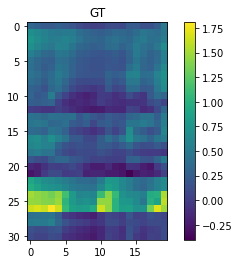

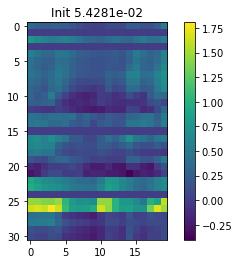

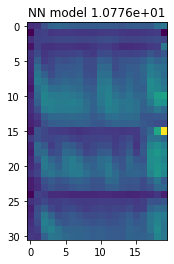

In [20]:
# Visualisation
#idxTr = np.random.permutation(y_train.shape[0])[0:2]
idxTt = np.random.permutation(y_test.shape[0])[0:10]
ii = 0

plt.figure(1)
#plt.subplot(3,2,1)
plt.imshow(x_valD[idxTt[ii],:,:].squeeze(),cmap='viridis')
plt.title('GT')
plt.colorbar()
#plt.subplot(3,2,3)
plt.figure(2)
plt.imshow(x_val_InitD[idxTt[ii],:,:].squeeze(),cmap='viridis')
plt.title('Init %.4e'%np.mean( (x_val_InitD[idxTt[ii],:,:]-x_valD[idxTt[ii],:,:])**2 ))
plt.colorbar()
#plt.subplot(3,2,5)
plt.figure(4)
plt.imshow(y_test[idxTt[ii],:,:].squeeze(),cmap='viridis')
plt.title('NN model %.4e'%np.mean( (y_test[idxTt[ii],:,:]-x_valD[idxTt[ii],:,:])**2 ))

In [21]:

ind = 50
station=31
print(mask_testD[ind,station,0])

plt.figure(1)
plt.plot(x_testD[ind,station,:])
plt.plot(ytest[ind,station,:])


IndexError: index 31 is out of bounds for axis 1 with size 31